<a href="https://colab.research.google.com/github/Wesley-Janson/transformers_for_human_vs_ai_text_identification/blob/main/BoW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torchtext.data.utils import get_tokenizer
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator


In [ ]:
PATH = 'Users/spavlekovsky/advanced ml/GPT-data-smaller.csv'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/GPT-data-smaller.csv"

raw_data = pd.read_csv(PATH)

Mounted at /content/gdrive


In [ ]:
raw_data = raw_data.iloc[1:100000]

In [ ]:
raw_data = raw_data.loc[(raw_data['generated_intro_len'] >= 34) & (raw_data['wiki_intro_len'] >= 34)]
data = pd.concat([
    pd.DataFrame({'intro': raw_data['generated_intro'], 'label': 1}),
    pd.DataFrame({'intro': raw_data['wiki_intro'], 'label': 0})]
).reset_index().drop('index', axis=1)
data['intro'] = data['intro'].apply(lambda s: s.split(' ', 7)[-1])
text = data['intro'].values
labels = data['label'].values
print(data)

                                                    intro  label
0       located in the town of Sexhow, on the Cumbrian...      1
1       animate or inanimate, have a spirit or "etiäin...      1
2       function theorem states that for every real-va...      1
3       and illustrated by Maki Fujii. The series foll...      1
4       29, 1973) is an American former professional b...      1
...                                                   ...    ...
293443  of Strategy and Intelligence Studies in the Sc...      0
293444  nearly extinct Pearic language of Cambodia and...      0
293445  American biologist who discovered the process ...      0
293446  Amsterdam, Netherlands. It was established in ...      0
293447  1733–1824) was an Italian Greek mathematician ...      0

[293448 rows x 2 columns]


In [ ]:
train_x, val_x, train_y, val_y = train_test_split(text, labels, test_size = 0.2)
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size = 0.5)

tokenizer = get_tokenizer("basic_english")

In [ ]:
MIN_VOCAB_FREQ = 200

In [ ]:
train_iter = iter(train_x)

def yield_tokens(train_iter):
    for text in train_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(
    yield_tokens(train_iter), specials=["<unk>"], min_freq=MIN_VOCAB_FREQ)
vocab.set_default_index(vocab.lookup_indices(["<unk>"])[0])
len(vocab)

11327

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(234758,)
(234758,)
(29345,)
(29345,)
(29345,)
(29345,)


In [ ]:
train_both = list(pd.DataFrame((train_x, train_y)).T.itertuples(index=False, name=None))
val_both = list(pd.DataFrame((val_x, val_y)).T.itertuples(index=False, name=None))
test_both = list(pd.DataFrame((test_x, test_y)).T.itertuples(index=False, name=None))


In [ ]:
from random import randint

def collate_into_bow(batch):
    batch_labels = torch.tensor([s[1] for s in batch])
    batch_tokens = torch.zeros([len(batch), len(vocab)])
    for i, s in enumerate(batch):
        all_tokens = tokenizer(s[0])
        if len(all_tokens) <= 27:
          continue
        start_index = randint(0, len(all_tokens)-27)
        sample_tokens = all_tokens[start_index:start_index+27]
        sample_dict = {}
        for t in sample_tokens:
            if t in sample_dict:
                sample_dict[t] += 1
            else:
                sample_dict[t] = 1
        for t in sample_dict:
            idx = vocab.lookup_indices([t])[0]
            batch_tokens[i, idx] = sample_dict[t]/27
    return batch_labels, batch_tokens

In [ ]:
train_loader = DataLoader(train_both, batch_size=10, shuffle=False, collate_fn=collate_into_bow)
val_loader = DataLoader(train_both, batch_size=10, shuffle=False, collate_fn=collate_into_bow)
test_loader = DataLoader(test_both, batch_size=10, shuffle=False, collate_fn=collate_into_bow)

In [ ]:
class BoWClassifier(nn.Module):
    def __init__(self, vocab_size, num_labels=2):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
        
    def forward(self, bow_vec):
        return self.linear(bow_vec)

In [ ]:

loss_function = torch.nn.CrossEntropyLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 1000

    for idx, (label, text) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)
        print(log_probs)
        print(label)
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()

In [ ]:
def get_accuracy(dataloader):
    model.eval()
    batch_accuracies = []
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            log_probs = model(text)
            matches = torch.eq(log_probs.argmax(1), label.T)
            batch_accuracies.append(matches.sum()/len(label))
    return torch.mean(torch.stack(batch_accuracies)).item()

In [ ]:
vocab_size = len(vocab)
model = BoWClassifier(vocab_size, 2)

EPOCHS = 15 # epoch
optimizer = torch.optim.Adam(model.parameters(), lr=3)

best_model = None
accuracies = []
for epoch in range(1, EPOCHS + 1):
    train_an_epoch(train_loader, optimizer)
    accuracy = get_accuracy(val_loader)
    accuracies.append(accuracy)
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}')
    print()
    if accuracies[-1] == max(accuracies):
        best_model = BoWClassifier(vocab_size, 2)
        best_model.load_state_dict(model.state_dict())
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [ ]:
def compute_metrics(predictions, targets):
    # Round predictions to get binary values
    rounded_preds = torch.round(torch.sigmoid(predictions))

    # Calculate true positives, false positives, and false negatives
    true_positives = torch.logical_and(rounded_preds == 1, targets == 1).sum().item()
    false_positives = torch.logical_and(rounded_preds == 1, targets == 0).sum().item()
    false_negatives = torch.logical_and(rounded_preds == 0, targets == 1).sum().item()

    # Calculate accuracy
    accuracy = torch.eq(rounded_preds, targets).sum().item() / targets.size(0)

    # Calculate precision and recall
    if true_positives + false_positives > 0:
        precision = true_positives / (true_positives + false_positives)
    else:
        precision = 0.0

    recall = true_positives / (true_positives + false_negatives)

    return accuracy, precision, recall

In [ ]:
train_accuracies = []
train_precisions = []
train_recalls = []
val_accuracies = []
val_precisions = []
val_recalls = []
test_accuracies = []
test_precisions = []
test_recalls = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_epoch(epoch):
    running_loss = 0.0
    total_predictions = []
    total_labels = []

    for i, data in enumerate(train_loader):
        labels, inputs = data
        if len(labels) == 10:
            optimizer.zero_grad()

            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            # Calculate metrics
            rounded_preds = torch.argmax(torch.round(torch.sigmoid(outputs)), dim=1)
            total_predictions.extend(rounded_preds.tolist())
            total_labels.extend(labels.tolist())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Print average loss every 100 batches
                average_loss = running_loss / 10
                accuracy, precision, recall = compute_metrics(torch.tensor(total_predictions), torch.tensor(total_labels))
                print(f"Epoch: {epoch+1}, Batch: {i+1}, Loss: {average_loss:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")
                running_loss = 0.0

                # Reset lists for next batch
                total_predictions = []
                total_labels = []

    return running_loss

In [ ]:
from pandas.errors import ValueLabelTypeMismatch
vocab_size = len(vocab)
model = BoWClassifier(vocab_size, 2)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.05)
# defining the loss function
criterion = torch.nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

epoch_number = 0
best_vloss = float('inf')

EPOCHS = 10

best_vloss = float('inf')
best_model = BoWClassifier(vocab_size, 2)
if torch.cuda.is_available():
    best_model = best_model.cuda()
train_losses = [] 
val_losses = []
test_losses = []
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_epoch(epoch_number)
    train_losses.append(avg_loss)

    # Where we're going, we don't need gradients
    model.eval() 

    running_vloss = 0.0
    total_val_predictions = []
    total_val_labels = []
    for i, vdata in enumerate(val_loader):
        vlabels, vinputs = vdata
        if len(vlabels) == 10:
          vinputs = vinputs.to(device=device)
          vlabels = vlabels.to(device=device) 
          voutputs = model(vinputs)
          vloss = criterion(voutputs, vlabels)
          running_vloss += vloss.item()

          # Calculate metrics for validation set
          rounded_vpreds = torch.argmax(torch.round(torch.sigmoid(voutputs)), dim=1)
          total_val_predictions.extend(rounded_vpreds.tolist())
          total_val_labels.extend(vlabels.tolist())
        else:
          pass
    avg_vloss = running_vloss / len(val_loader)
    val_losses.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    val_accuracy, val_precision, val_recall = compute_metrics(torch.tensor(total_val_predictions), torch.tensor(total_val_labels))
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_model.load_state_dict(model.state_dict())

    epoch_number += 1

# After all epochs, evaluate the model on the test set
best_model.eval()  # Ensure the model is in evaluation mode
running_test_loss = 0.0
total_test_predictions = []
total_test_labels = []

for i, tdata in enumerate(test_loader):
    tlabels, tinputs = tdata
    if len(tlabels) == 10:
      tinputs = tinputs.to(device=device)
      tlabels = tlabels.to(device=device)
      toutputs = best_model(tinputs)
      tloss = criterion(toutputs, tlabels)
      running_test_loss += tloss.item()
      # Calculate metrics for test set
      rounded_tpreds = torch.argmax(torch.round(torch.sigmoid(toutputs)), dim=1)
      total_test_predictions.extend(rounded_tpreds.tolist())
      total_test_labels.extend(tlabels.tolist())

avg_test_loss = running_test_loss / len(test_loader)
test_losses.append(avg_test_loss)
test_accuracy, test_precision, test_recall = compute_metrics(torch.tensor(total_test_predictions), torch.tensor(total_test_labels))
test_accuracies.append(test_accuracy)
test_precisions.append(test_precision)
test_recalls.append(test_recall)
print('Test Loss: {}'.format(avg_test_loss))

EPOCH 1:
Epoch: 1, Batch: 100, Loss: 6.819, Accuracy: 0.566, Precision: 0.555, Recall: 0.587
Epoch: 1, Batch: 200, Loss: 6.416, Accuracy: 0.664, Precision: 0.677, Recall: 0.576
Epoch: 1, Batch: 300, Loss: 6.231, Accuracy: 0.655, Precision: 0.658, Recall: 0.702
Epoch: 1, Batch: 400, Loss: 6.018, Accuracy: 0.692, Precision: 0.692, Recall: 0.732
Epoch: 1, Batch: 500, Loss: 5.950, Accuracy: 0.693, Precision: 0.700, Recall: 0.685
Epoch: 1, Batch: 600, Loss: 5.880, Accuracy: 0.704, Precision: 0.704, Recall: 0.701
Epoch: 1, Batch: 700, Loss: 5.815, Accuracy: 0.706, Precision: 0.720, Recall: 0.692
Epoch: 1, Batch: 800, Loss: 5.564, Accuracy: 0.725, Precision: 0.719, Recall: 0.737
Epoch: 1, Batch: 900, Loss: 5.616, Accuracy: 0.707, Precision: 0.722, Recall: 0.698
Epoch: 1, Batch: 1000, Loss: 5.675, Accuracy: 0.708, Precision: 0.714, Recall: 0.731
Epoch: 1, Batch: 1100, Loss: 5.447, Accuracy: 0.724, Precision: 0.725, Recall: 0.673
Epoch: 1, Batch: 1200, Loss: 5.382, Accuracy: 0.743, Precision: 0

In [ ]:
train_accuracies

[]

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, EPOCHS+1)

# # Plot the training and validation loss values
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(epochs, train_losses, label='Training Loss')
# plt.plot(epochs, val_losses, label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(loc='best')

# # Plot the training and validation accuracy values
# plt.subplot(1, 2, 2)
# plt.plot(epochs, train_accuracies, label='Training Accuracy')
# plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend(loc='best')

# plt.tight_layout()
# plt.show()


# Print test metrics
print("Test Loss: {:.4f}".format(avg_test_loss))
print("Test Accuracy: {:.4f}".format(test_accuracy))
print("Test Precision: {:.4f}".format(test_precision))
print("Test Recall: {:.4f}".format(test_recall))

Test Loss: 0.4654
Test Accuracy: 0.7854
Test Precision: 0.7875
Test Recall: 0.7841


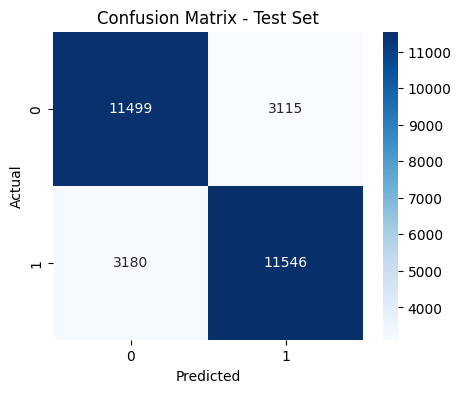

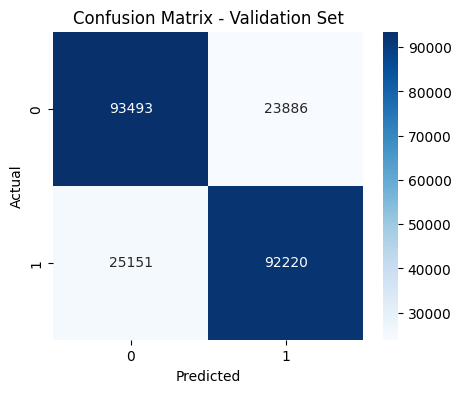

In [ ]:
import seaborn

# Create a confusion matrix for the test set
test_confusion = confusion_matrix(total_test_labels, total_test_predictions)
plt.figure(figsize=(5, 4))
seaborn.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Create a confusion matrix for the validation set
val_confusion = confusion_matrix(total_val_labels, total_val_predictions)
plt.figure(figsize=(5, 4))
seaborn.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()